This pipline is for identifying the bi-cone feature in MaNGA Galaxies.
The way to identify the feature would be:
1. transforming a OIII map to polar coordinate.
2. Spread the polar coordinate back in a Cartesian coordinate
3. Take the average flux of each column to make a histogram
4. Analyze the feature in the histogram using Gaussian blurring or ?
5. Compare samples to see if the pipeline would work for its purpose. 

Jun. 21, 2022

In [1]:
import numpy as np
import cv2
import scipy as scipy
import scipy.interpolate
import matplotlib.pyplot as plt
from astropy.io import fits
import polarTransform
from astropy.utils.data import get_pkg_data_filename
from scipy.stats import wasserstein_distance

[INFO]: No release version set. Setting default to DR17
[WARNING]: path /Users/runquanguan/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /Users/runquanguan/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: Passing field metadata as keyword arguments is deprecated. Use the explicit `metadata=...` argument instead. Additional metadata: {'location': 'view_args'} (RemovedInMarshmallow4Warning)
[WARNING]: The 'missing' argument to fields is deprecated. Use 'load_default' instead. (RemovedInMarshmallow4Warning)


## importing MAPS 

In [8]:
#Load PATH:

plateifu = '8240-6103' 

maps = Maps(plateifu, bintype='SPX', template='MILESHC-MASTARSSP')
FOLDER = '/Users/runquanguan/Documents/Research/MaNGA-AGN/Data/'
FILENAME = 'manga-' + plateifu + '-MAPS-SPX-MILESHC-MASTARSSP.fits'
PATH = FOLDER+FILENAME


#PATH for bicone featured galaxies:
'''
BC_PATH = '/Users/runquanguan/Documents/Research/MaNGA-AGN/Pipeline&Instrction/obvious_bicone_feature_position.fits'
BC_hdul = fits.open(PATH)
BC_hdu = hdul[1].data
#extract MAPS from MARVIN:
for data in BC_hdu:
    maps = Maps(str(data[0]), bintype='SPX', template='MILESHC-MASTARSSP')
'''

"\nBC_PATH = '/Users/runquanguan/Documents/Research/MaNGA-AGN/Pipeline&Instrction/obvious_bicone_feature_position.fits'\nBC_hdul = fits.open(PATH)\nBC_hdu = hdul[1].data\n#extract MAPS from MARVIN:\nfor data in BC_hdu:\n    maps = Maps(str(data[0]), bintype='SPX', template='MILESHC-MASTARSSP')\n"

In [9]:
#Load MAPS:

image_file = get_pkg_data_filename(PATH)

#Non-parametric equivalent widths measurements
EMLINE_SEW = fits.getdata(image_file, ext=26)
#Gaussian-fitted equivalent widths measurements  (we use this one)
EMLINE_GEW = fits.getdata(image_file, ext=33)

#Channel of Elements: 
#'OIII-5008'          / Data in channel 17 
#'Ha-6564 '           / Data in channel 24
#'Hb-4862 '           / Data in channel 15
#'NII-6585'           / Data in channel 25
#'SII-6732'           / Data in channel 27
DATA = EMLINE_GEW[16]
DATA.shape

(54, 54)

#Print Image for test
plt.imshow(DATA, cmap='viridis',vmin=0, vmax=1.6)
plt.title(r'$EW_{OIII}$')
plt.gca().invert_yaxis()
plt.colorbar(orientation='vertical',label = r'$log(\AA)$')
plt.show()

## Find the coordinate of flux center pixel

In [10]:
# Find the index of the galaxy through header file
HEADER_PATH = '/Users/runquanguan/Documents/dapall-v3_1_1-3.1.0.fits'
header_hdul = fits.open(HEADER_PATH)
SPX_MILESHC_MASTARSSP = header_hdul[1]
header_plateifu = SPX_MILESHC_MASTARSSP.data['PLATEIFU']
galaxy_index = list(header_plateifu).index(plateifu)

# Find the center coordinate RA/DEC
RA = SPX_MILESHC_MASTARSSP.data['OBJRA'][galaxy_index]
DEC = SPX_MILESHC_MASTARSSP.data['OBJDEC'][galaxy_index]

# Find the IFU pointing RA/DEC
IFURA = SPX_MILESHC_MASTARSSP.data['IFURA'][galaxy_index]
IFUDEC = SPX_MILESHC_MASTARSSP.data['IFUDEC'][galaxy_index]

#IFURA == RA and IFUDEC == DEC # check if IFU is point correct

# It turned out that each image is centered already, 
# but different in shapes! 
EMLINE_GEW[16].shape[0]

54

## Transform image to Polar Coordinate

In [11]:
# First we need to remove the 3-sigma data

mean = np.mean(EMLINE_GEW[16])
sd = np.std(EMLINE_GEW[16])

sigma_lw = mean - 1 * sd
sigma_up =  mean + 1 * sd

cartesianImage = EMLINE_GEW[16]

w = EMLINE_GEW[16].shape[0]
h = EMLINE_GEW[16].shape[1]

polarImage, ptSettings = polarTransform.convertToPolarImage(EMLINE_GEW[16], center=[round(w/2), round(h/2)])

plt.imshow(polarImage.T, origin='upper', cmap='viridis',vmin=sigma_lw, vmax=sigma_up)
plt.title(r'$EW_{OIII}$')
plt.gca().invert_yaxis()
plt.colorbar(orientation='vertical',label = r'$log(\AA)$')
plt.show()

## Now let's integrate each column

In [14]:
# Integrate the column
EW_COL = [sum(x)/polarImage.T.shape[0] for x in zip(*polarImage.T)]

# Exclude outlier using 3-sigma variant
mean = np.mean(EW_COL)
sd = np.std(EW_COL)
EW_CLEAN = [x for x in EW_COL if (x >= mean - 2 * sd)]
EW_CLEAN = [x for x in EW_CLEAN if (x <= mean + 2 * sd)]
# Smoothening the curve using Gaussian filter
EW_SMO = scipy.ndimage.gaussian_filter(EW_CLEAN, sigma = 5)

# To better identify the feature, plot two cycles of the galaxy
EW_SMO_TW = list(np.append(EW_SMO, EW_SMO))

# limited the array to exactly one cycle: but from min to min
min_index = min(EW_SMO_TW, default = 0) # find min value
start_index = [i for i, n in enumerate(EW_SMO_TW) if n == min_index][0] # find index of 1st min
end_index = [i for i, n in enumerate(EW_SMO_TW) if n == min_index][1] # find index of 2nd min
trunc_EW = np.array(EW_SMO_TW[start_index:end_index]) # truncate from 1st to 2nd min

# Correct the 0 data error first:
if len(trunc_EW) <= 4:
    trunc_EW = np.linspace(0,200,200)
else:
    pass
# Normalization 
norm = np.linalg.norm(trunc_EW)
norm_EW = trunc_EW/norm

# Make them all to the same length through interpolation
x = np.linspace(0,len(norm_EW),len(norm_EW))
y = norm_EW
x2 = np.linspace(0,len(norm_EW),500)
f_linear = scipy.interpolate.interp1d(x, y)
intp_EW = f_linear(x2)



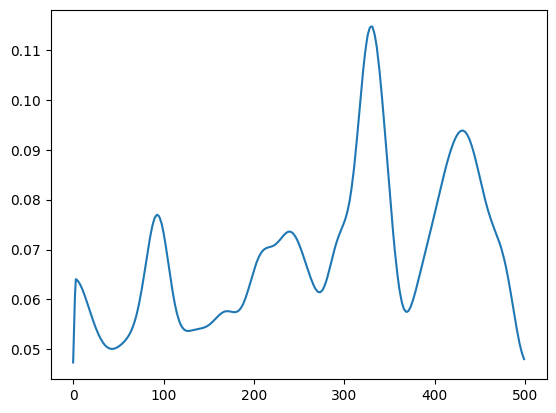

In [13]:
# Integrate the column
EW_COL = [sum(x)/polarImage.T.shape[0] for x in zip(*polarImage.T)]

# Exclude outlier by smoothening the curve
mean = np.mean(EW_COL)
sd = np.std(EW_COL)

EW_CLEAN = [x for x in EW_COL if (x >= mean - 2 * sd)]
EW_CLEAN = [x for x in EW_CLEAN if (x <= mean + 2 * sd)]

EW_SMO = scipy.ndimage.gaussian_filter(EW_CLEAN, sigma = 5)

# To better identify the feature, let's plot two cycles of the galaxy
EW_SMO_TW = list(np.append(EW_SMO, EW_SMO))

# limited the array to exactly one cycle: from min to mimn
min_index = min(EW_SMO_TW, default=0)
start_index = [i for i, n in enumerate(EW_SMO_TW) if n == min_index][0]
end_index = [i for i, n in enumerate(EW_SMO_TW) if n == min_index][1]
trunc_EW = np.array(EW_SMO_TW[start_index:end_index])

# Normalization 
# Correct the 0 data error first:
if len(trunc_EW) <= 4:
    trunc_EW = np.linspace(0,200,200)
else:
    pass

norm = np.linalg.norm(trunc_EW)
norm_EW = trunc_EW/norm

# Make them all to the same length
x = np.linspace(0,len(norm_EW),len(norm_EW))
y = norm_EW
x2 = np.linspace(0,len(norm_EW),500)
f_linear = scipy.interpolate.interp1d(x, y)

intp_EW = f_linear(x2)

plt.plot(intp_EW)
plt.show()

In [14]:
#Blacklist:
'8479-6104'

'8479-6104'